# 概要
「特徴量自動生成」→「特徴量選択」→「HPO」の流れをRandomForestRegressiorでなんとなくやってみる。  
これが簡単にできたら、とりあえずデータ渡された時の初動がよくなりそう。  
（あくまでも、初動がよくなるだけ）


# 1.特徴量自動生成　
[featuretools](https://github.com/Featuretools/featuretools)をINSTALL  
[このブログ](https://qiita.com/Hyperion13fleet/items/4eaca365f28049fe11c7)も参考になる。  
[公式doc](https://docs.featuretools.com/index.html)  
[論文](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf)

In [1]:
!pip install featuretools

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
# データの読み込み
import pandas as pd

items = pd.read_csv('/home/ec2-user/SageMaker/work/work_20190105/machinelearning/time_analysis/data/kaggle/ts/items.csv')
cats = pd.read_csv('/home/ec2-user/SageMaker/work/work_20190105/machinelearning/time_analysis/data/kaggle/ts/item_categories.csv')
train = pd.read_csv('/home/ec2-user/SageMaker/work/work_20190105/machinelearning/time_analysis/data/kaggle/ts/sales_train.csv.gz', compression='gzip')

In [7]:
# 検証用に「cats」Entityに列を追加
# faturetoolsで、trainに紐づいた時にこの「cats」Entityの列も特徴量生成に利用されるかの確認をする。
# 適当に、「商品カテゴリごとにMAXの販売価格」を意識して列を追加しておく

from numpy.random import randint

cats['price_max'] = randint(low=100, high=2000, size=len(cats))

# Entity Setとして取り込み
下記を参考。

[Representing Data with EntitySets](https://docs.featuretools.com/loading_data/using_entitysets.html)  
[entity_from_dataframe](https://docs.featuretools.com/generated/featuretools.EntitySet.entity_from_dataframe.html#featuretools.EntitySet.entity_from_dataframe)


In [8]:
%%time

import featuretools as ft
print('ft_version:{}'.format(ft.__version__))

# Entity Setを作成
es = ft.EntitySet(id='entityset') # RDBで言う所のスキーマ

# Entityの追加(RDBで言う所のテーブル)
es = es.entity_from_dataframe(entity_id="items",# テーブル名のようなもの
                              dataframe=items,# 読み込み対象のDF
                              index="item_id",# RDBのテーブルで言うところの主キー（なので、一意にならないとダメ）。
                              variable_types={"item_category_id": ft.variable_types.Id} # IDとして扱う
                             )

es = es.entity_from_dataframe(entity_id="cats",
                              dataframe=cats,
                              index="item_category_id"
                             )

es = es.entity_from_dataframe(entity_id="train",
                              dataframe=train,
                              index = 'train_index', # 新しく作るインデックスの名前を指定
                              make_index=True, # 複合主キーが作れない仕様なので、新しくキーを作成する。
                              variable_types={"shop_id": ft.variable_types.Id,
                                              "item_id": ft.variable_types.Id
                                             }
                             )

es

ft_version:0.5.1
CPU times: user 3min 34s, sys: 206 ms, total: 3min 35s
Wall time: 3min 39s


# Entityの関係性と作成する特徴量を定義

>we specify how the entities are related.
When two entities have a one-to-many relationship, we call the “one” enitity, the “parent entity”. 
A relationship between a parent and child is defined like this:

[引用元](https://docs.featuretools.com/index.html)


In [9]:
# 関係性の定義
relationship_items_train = ft.Relationship(parent_variable= es["items"]["item_id"] # 親entityを指定（結合キーが重複しない）。マスターテーブルのようなイメージ。
                                   ,child_variable=es["train"]["item_id"] # 子entityを指定（結合キーが重複しても良い）。トランザクションテーブルのようなイメージ。
                                  ) 
relationship_cats_items = ft.Relationship(parent_variable= es["cats"]["item_category_id"]
                                   ,child_variable=es["items"]["item_category_id"]
                                  ) 

# 関係性を認識する
es = es.add_relationship(relationship_items_train)
es = es.add_relationship(relationship_cats_items)

# どんな特徴量を生成するか。この引数を指定しなければ、デフォルトだともっと色々な特徴量も生成できる
agg_primitives = ["sum", "max","min","count"] # 集計系
trans_primitives = ["day", "year","month","weekday"] # 変換系

# Run Deep Feature Synthesis

特徴量生成!
https://docs.featuretools.com/index.html#run-deep-feature-synthesis  
[dfs](https://docs.featuretools.com/generated/featuretools.dfs.html)

# 特徴量生成

In [10]:
%%time

# 特徴量生成
# https://docs.featuretools.com/generated/featuretools.dfs.html
feature_matrix, features_defs = ft.dfs(entityset=es,
                                       target_entity="train",
                                       agg_primitives=agg_primitives, # Default: [“sum”, “std”, “max”, “skew”, “min”, “mean”, “count”, “percent_true”, “n_unique”, “mode”]
                                       trans_primitives=trans_primitives, # Default: [“day”, “year”, “month”, “weekday”, “haversine”, “num_words”, “num_characters”]
                                       max_depth=2,
                                       verbose=True
                                      )

print('shape:{}'.format(feature_matrix.shape))
print(feature_matrix.sample(5))

Built 23 features
Elapsed: 01:06 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
shape:(2935849, 23)
             date_block_num  item_price  item_cnt_day  shop_id  item_id  \
train_index                                                               
2039206                  21       999.0           1.0       25    19500   
1124720                  11       149.0           1.0       25    18721   
1556871                  15       224.0           1.0       58     6108   
789028                    7       749.0           1.0       24    16533   
293247                    2       449.0           1.0        7     3223   

             DAY(date)  YEAR(date)  MONTH(date)  WEEKDAY(date)  \
train_index                                                      
2039206             10        2014            2              0   
1124720             27        2013           12              4   
1556871              4        2014            5              6   
789028            

In [11]:
feature_matrix.head()

,date_block_num,item_price,item_cnt_day,shop_id,item_id,DAY(date),YEAR(date),MONTH(date),WEEKDAY(date),items.item_name,...,items.SUM(train.item_cnt_day),items.MAX(train.date_block_num),items.MAX(train.item_price),items.MAX(train.item_cnt_day),items.MIN(train.date_block_num),items.MIN(train.item_price),items.MIN(train.item_cnt_day),items.COUNT(train),items.cats.item_category_name,items.cats.price_max
train_index,,,,,,,,,,,,,,,,,,,,,
0,0,999.00,1.0,59,22154,1,2013,2,4,ЯВЛЕНИЕ 2012 (BD),...,59.0,33,999.00,1.0,0,299.00,1.0,59,Кино - Blu-Ray,719
1,0,899.00,1.0,25,2552,1,2013,3,4,DEEP PURPLE The House Of Blue Light LP,...,5.0,28,949.00,1.0,0,899.00,-1.0,9,Музыка - Винил,1055
2,0,899.00,-1.0,25,2552,1,2013,5,2,DEEP PURPLE The House Of Blue Light LP,...,5.0,28,949.00,1.0,0,899.00,-1.0,9,Музыка - Винил,1055
3,0,1709.05,1.0,25,2554,1,2013,6,5,DEEP PURPLE Who Do You Think We Are LP,...,1.0,0,1709.05,1.0,0,1709.05,1.0,1,Музыка - Винил,1055
4,0,1099.00,1.0,25,2555,15,2013,1,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),...,56.0,21,1149.00,1.0,0,1098.70,1.0,56,Музыка - CD фирменного производства,1729


# 2.特徴量選択
[boruta](https://github.com/scikit-learn-contrib/boruta_py)をINSTALLL  
なお、「boruta」はそのアルゴリズムの性質から、「変数重要度」がわかるアルゴリズムにしか適用できない点に注意  

「boruta」のアルゴリズム概要については、[こちら](https://aotamasaki.hatenablog.com/entry/2019/01/05/195813)を参照しよう。わかりやすい。  

### 注意点
「featuretools」を使って、「カテゴリ型変数」とかを引っ張ってきちゃうと、「boruta」では扱えないのでエラーになるよ。  
one-hot-encodingするか、もしくは対象カラムを削除しよう。  

In [12]:
!pip install --upgrade pip
!pip install boruta

    100% |████████████████████████████████| 1.3MB 23.8MB/s 
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
    100% |████████████████████████████████| 61kB 26.2MB/s 
  Running setup.py bdist_wheel for boruta ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/5c/5a/72/13e8ea10ba10e22e9ca7f76f8b451c9f98fa190d428c8857dd
Successfully built boruta


# 学習前のデータの準備

In [13]:
import pandas as pd

X_train = feature_matrix[feature_matrix.date_block_num < 33].drop(['item_cnt_day'], axis=1)
Y_train = feature_matrix[feature_matrix.date_block_num < 33]['item_cnt_day']
X_valid = feature_matrix[feature_matrix.date_block_num == 33].drop(['item_cnt_day'], axis=1)
Y_valid = feature_matrix[feature_matrix.date_block_num == 33]['item_cnt_day']

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(2882335, 22)
(2882335,)
(53514, 22)
(53514,)


In [15]:
X_train.head()

,date_block_num,item_price,shop_id,item_id,DAY(date),YEAR(date),MONTH(date),WEEKDAY(date),items.item_name,items.item_category_id,...,items.SUM(train.item_cnt_day),items.MAX(train.date_block_num),items.MAX(train.item_price),items.MAX(train.item_cnt_day),items.MIN(train.date_block_num),items.MIN(train.item_price),items.MIN(train.item_cnt_day),items.COUNT(train),items.cats.item_category_name,items.cats.price_max
train_index,,,,,,,,,,,,,,,,,,,,,
0,0,999.00,59,22154,1,2013,2,4,ЯВЛЕНИЕ 2012 (BD),37,...,59.0,33,999.00,1.0,0,299.00,1.0,59,Кино - Blu-Ray,719
1,0,899.00,25,2552,1,2013,3,4,DEEP PURPLE The House Of Blue Light LP,58,...,5.0,28,949.00,1.0,0,899.00,-1.0,9,Музыка - Винил,1055
2,0,899.00,25,2552,1,2013,5,2,DEEP PURPLE The House Of Blue Light LP,58,...,5.0,28,949.00,1.0,0,899.00,-1.0,9,Музыка - Винил,1055
3,0,1709.05,25,2554,1,2013,6,5,DEEP PURPLE Who Do You Think We Are LP,58,...,1.0,0,1709.05,1.0,0,1709.05,1.0,1,Музыка - Винил,1055
4,0,1099.00,25,2555,15,2013,1,1,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,...,56.0,21,1149.00,1.0,0,1098.70,1.0,56,Музыка - CD фирменного производства,1729


In [16]:
X_train.columns

Index(['date_block_num', 'item_price', 'shop_id', 'item_id', 'DAY(date)',
       'YEAR(date)', 'MONTH(date)', 'WEEKDAY(date)', 'items.item_name',
       'items.item_category_id', 'items.SUM(train.date_block_num)',
       'items.SUM(train.item_price)', 'items.SUM(train.item_cnt_day)',
       'items.MAX(train.date_block_num)', 'items.MAX(train.item_price)',
       'items.MAX(train.item_cnt_day)', 'items.MIN(train.date_block_num)',
       'items.MIN(train.item_price)', 'items.MIN(train.item_cnt_day)',
       'items.COUNT(train)', 'items.cats.item_category_name',
       'items.cats.price_max'],
      dtype='object')

In [17]:
# カテゴリ変数(oheにすればOKだが),leakになりそうなカラムを外す

X_train = X_train.drop(['items.item_name'], axis=1)
X_train = X_train.drop(['items.cats.item_category_name'], axis=1)
X_train = X_train.drop(['items.MAX(train.item_cnt_day)'], axis=1)
X_train = X_train.drop(['items.SUM(train.item_cnt_day)'], axis=1)
X_train = X_train.drop(['items.MIN(train.item_cnt_day)'], axis=1)

X_valid = X_valid.drop(['items.item_name'], axis=1)
X_valid = X_valid.drop(['items.cats.item_category_name'], axis=1)
X_valid = X_valid.drop(['items.MAX(train.item_cnt_day)'], axis=1)
X_valid = X_valid.drop(['items.SUM(train.item_cnt_day)'], axis=1)
X_valid = X_valid.drop(['items.MIN(train.item_cnt_day)'], axis=1)

print(X_train.shape)
print(X_valid.shape)
print(X_train.head())
print(X_valid.head())

(2882335, 17)
(53514, 17)
             date_block_num  item_price  shop_id  item_id  DAY(date)  \
train_index                                                            
0                         0      999.00       59    22154          1   
1                         0      899.00       25     2552          1   
2                         0      899.00       25     2552          1   
3                         0     1709.05       25     2554          1   
4                         0     1099.00       25     2555         15   

             YEAR(date)  MONTH(date)  WEEKDAY(date)  items.item_category_id  \
train_index                                                                   
0                  2013            2              4                      37   
1                  2013            3              4                      58   
2                  2013            5              2                      58   
3                  2013            6              5                      5

In [18]:
# 欠損値の含まれる行を削除

X_train.dropna(how='all',inplace=True)
X_valid.dropna(how='all',inplace=True)

print(X_train.shape)
print(X_valid.shape)

(2882335, 17)
(53514, 17)


# ベースラインの計測

borutaの効果を見るために、一回ベースラインを計測する。

In [19]:
%%time

from sklearn.ensemble import RandomForestRegressor

# model
model = RandomForestRegressor(
    n_estimators=50
    , criterion='mse'
    , max_depth = 7
    , max_features = 'sqrt' 
    , n_jobs=-1
    , verbose=1
    )

model.fit(X_train.values, Y_train.values)

# 評価指標
print('train:{}'.format(model.score(X_train, Y_train)))
print('val:{}'.format(model.score(X_valid, Y_valid)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


train:0.17968478871529892
val:0.011998556354997691
CPU times: user 4min 57s, sys: 873 ms, total: 4min 58s
Wall time: 1min 20s


# boruta適用前の、各特徴量の重要度

1   item_price   0.2205027958923571
2   items.MAX(train.item_price)   0.10192454777143942
3   items.SUM(train.date_block_num)   0.10129157912314703
4   shop_id   0.09744208466216935
5   items.COUNT(train)   0.08391596023996081
6   date_block_num   0.0707432556168701
7   DAY(date)   0.06655464431992658
8   MONTH(date)   0.052352716804110744
9   items.MIN(train.item_price)   0.0514269716006315
10   items.item_category_id   0.03063023979757261
11   items.SUM(train.item_price)   0.030586499761355298
12   WEEKDAY(date)   0.024529048035699597
13   item_id   0.02097104743573632
14   items.MIN(train.date_block_num)   0.014429615775331882
15   items.cats.price_max   0.013094114304054542
16   YEAR(date)   0.010900472763055724
17   items.MAX(train.date_block_num)   0.008704406096581272


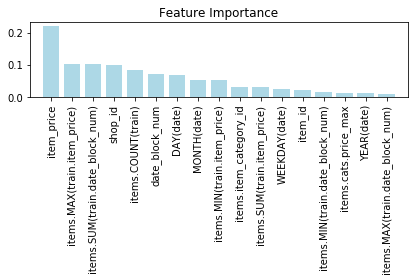

In [20]:
#特徴量の重要度
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


feature = model.feature_importances_

#特徴量の重要度を上から順に出力する
f = pd.DataFrame({'number': range(0, len(feature)),
             'feature': feature[:]})
f2 = f.sort_values('feature',ascending=False)
f3 = f2.loc[:, 'number']

#特徴量の名前
label = X_train.columns[0:]

#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

for i in range(len(feature)):
    print(str(i + 1) + "   " + str(label[indices[i]]) + "   " + str(feature[indices[i]]))

plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

# borutaを適用

In [21]:
%%time

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# model
model = RandomForestRegressor(
    n_estimators=50
    , criterion='mse'
    , max_depth = 7
    , max_features = 'sqrt' 
    , n_jobs=-1
    , verbose=True
    )

# define Boruta feature selection method
# https://github.com/scikit-learn-contrib/boruta_py/blob/master/boruta/boruta_py.py
feat_selector = BorutaPy(model, 
                         n_estimators='auto',  # 特徴量の数に比例して、木の本数を増やす
                         verbose=2, # 0: no output,1: displays iteration number,2: which features have been selected already
                         alpha=0.05, # 特徴量を棄却する基準のp値
                         max_iter=30, # 反復回数
                         random_state=1
                        )

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train.values, Y_train.values)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	17
Rejected: 	0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  2.7min finished


Iteration: 	8 / 30
Confirmed: 	4
Tentative: 	8
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  2.0min finished


Iteration: 	9 / 30
Confirmed: 	4
Tentative: 	8
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  2.1min finished


Iteration: 	10 / 30
Confirmed: 	4
Tentative: 	8
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  2.1min finished


Iteration: 	11 / 30
Confirmed: 	4
Tentative: 	8
Rejected: 	5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  2.1min finished


Iteration: 	12 / 30
Confirmed: 	4
Tentative: 	7
Rejected: 	6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  1.9min finished


Iteration: 	13 / 30
Confirmed: 	4
Tentative: 	7
Rejected: 	6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  2.0min finished


Iteration: 	14 / 30
Confirmed: 	4
Tentative: 	7
Rejected: 	6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  1.9min finished


Iteration: 	15 / 30
Confirmed: 	4
Tentative: 	7
Rejected: 	6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  1.9min finished


Iteration: 	16 / 30
Confirmed: 	4
Tentative: 	5
Rejected: 	8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


Iteration: 	17 / 30
Confirmed: 	4
Tentative: 	5
Rejected: 	8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


Iteration: 	18 / 30
Confirmed: 	4
Tentative: 	5
Rejected: 	8


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


Iteration: 	19 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	20 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	21 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	22 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	23 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	24 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	25 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	26 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	27 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	28 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  1.7min finished


Iteration: 	29 / 30
Confirmed: 	5
Tentative: 	3
Rejected: 	9


BorutaPy finished running.

Iteration: 	30 / 30
Confirmed: 	5
Tentative: 	0
Rejected: 	9
CPU times: user 3h 53min 38s, sys: 27.5 s, total: 3h 54min 5s
Wall time: 1h 56s


In [22]:
# どの列が選ばれたか、の確認
feat_selector.support_

array([False,  True,  True, False, False, False, False, False, False,
        True, False, False,  True, False, False,  True, False])

In [23]:
# 重要度に基づいたランキング
feat_selector.ranking_

array([ 2,  1,  1,  5,  5, 10,  4, 11,  2,  1,  7, 12,  1,  8,  2,  1,  9])

In [24]:
# 選ばれた特徴量のみの配列を作成

X_train_selected = X_train.iloc[:,feat_selector.support_]
X_valid_selected = X_valid.iloc[:,feat_selector.support_]

In [25]:
X_train.head()

,date_block_num,item_price,shop_id,item_id,DAY(date),YEAR(date),MONTH(date),WEEKDAY(date),items.item_category_id,items.SUM(train.date_block_num),items.SUM(train.item_price),items.MAX(train.date_block_num),items.MAX(train.item_price),items.MIN(train.date_block_num),items.MIN(train.item_price),items.COUNT(train),items.cats.price_max
train_index,,,,,,,,,,,,,,,,,
0,0,999.00,59,22154,1,2013,2,4,37,798,41473.00,33,999.00,0,299.00,59,719
1,0,899.00,25,2552,1,2013,3,4,58,65,8441.00,28,949.00,0,899.00,9,1055
2,0,899.00,25,2552,1,2013,5,2,58,65,8441.00,28,949.00,0,899.00,9,1055
3,0,1709.05,25,2554,1,2013,6,5,58,0,1709.05,0,1709.05,0,1709.05,1,1055
4,0,1099.00,25,2555,15,2013,1,1,56,418,62893.70,21,1149.00,0,1098.70,56,1729


In [26]:
X_train_selected.head()

,item_price,shop_id,items.SUM(train.date_block_num),items.MAX(train.item_price),items.COUNT(train)
train_index,,,,,
0,999.00,59,798,999.00,59
1,899.00,25,65,949.00,9
2,899.00,25,65,949.00,9
3,1709.05,25,0,1709.05,1
4,1099.00,25,418,1149.00,56


# モデルを再度学習

In [27]:
from sklearn.ensemble import RandomForestRegressor

# model
model = RandomForestRegressor(
    n_estimators=50
    , criterion='mse'
    , max_depth = 7
    , min_samples_split = 2
    , max_features = 'sqrt' 
    , n_jobs=-1
    , verbose=1
    )

model.fit(X_train_selected.values, Y_train.values)

# 評価指標
print('train:{}'.format(model.score(X_train_selected, Y_train)))
print('val:{}'.format(model.score(X_valid_selected, Y_valid)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   55.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s


train:0.21540294985590158
val:0.05816407096609288


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


ベースラインと比較して、検証データセットでの精度が向上していることが確認できた。  
(数字としては全然使い物にならないが...)  

今回は全体としての使い方を習得することを目的とするので、続いて特徴量を一旦出力しておく。

In [118]:
# 出力

X_train_selected.to_csv('x_train_selected.csv')
Y_train.to_csv('y_train.csv')
X_valid_selected.to_csv('x_valid_selected.csv')
Y_valid.to_csv('y_valid.csv')

# 取り込み
import pandas as pd

X_train_selected = pd.read_csv('x_train_selected.csv', header=0)
Y_train = pd.read_csv('y_train.csv', header=None)
X_valid_selected = pd.read_csv('x_valid_selected.csv', header=0)
Y_valid = pd.read_csv('y_valid.csv', header=None)

print(X_train_selected.shape)
print(Y_train.shape)
print(X_valid_selected.shape)
print(Y_valid.shape)

(2882335, 7)
(2882335, 2)
(53514, 7)
(53514, 2)


# 3.ハイパーパラメータチューニング

「特徴量自動生成」→「特徴量選択」と来たので、最後にハイパーパラメータチューニングをする。  
[optuna](https://optuna.org/)を使うよ。

In [1]:
# インストール
!pip install --upgrade pip
!pip install optuna

    100% |████████████████████████████████| 1.3MB 22.9MB/s 
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
    100% |████████████████████████████████| 61kB 15.4MB/s 
    100% |████████████████████████████████| 81kB 31.2MB/s 
    100% |████████████████████████████████| 51kB 28.5MB/s 
    100% |████████████████████████████████| 92kB 35.3MB/s 
  Running setup.py bdist_wheel for optuna ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/6b/35/b5/c8dda18e03a24da1fb839ccf5ec7ddda34469ab7cb5f4ff831
  Running setup.py bdist_wheel for PrettyTable ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Running setup.py bdist_wheel for pyperclip ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/92/f0/ac/2ba2972034e98971c3654ece337ac61e546bdeb34ca960dc8c
Successfully built optuna PrettyTable pyperclip


# 学習部分の記述
探索するハイパーパラメータの範囲もここで書くよ。

In [119]:
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    '''
    trial:set of hyperparameter    
    '''
    # hypyer param
    max_depth = trial.suggest_int('max_depth', 3, 10) # 深すぎると過学習になるかも...
    n_estimators = trial.suggest_int('n_estimators', 50, 100) # しっかりやるなら100以上がいいかも
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'auto', 'log2'])
    
    # model
    model = RandomForestRegressor(max_depth=max_depth,
                                  n_estimators=n_estimators,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  verbose=1)
    
    # fit
    model.fit(X_train_selected.values, Y_train.values)
    
    # eval
    score = -1 * model.score(X_valid_selected.values, Y_valid.values) 
    return score

# HPOの実行

In [120]:
%%time

study = optuna.create_study()

# https://optuna.readthedocs.io/en/stable/reference/study.html#optuna.study.Study.optimize
study.optimize(func=objective, # 実行する関数
               n_trials=4, # HPO試行回数
               timeout=None, # 与えられた秒数後に学習を中止します。default=None
               n_jobs=-1 # 並列実行するjob数
              )

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  68 out of  68 | elapsed:    0.2s finished
[I 2019-01-16 10:14:26,033] Finished a trial resulted in value: 8653.64057556307. Current best value is 8653.64057556307 with parameters: {'max_depth': 6, 'n_estimators': 68, 'max_features': 'log2'}.
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:  5.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  95 out of  95 | elapsed:    0.2s finished
[I 2019-01-16 10:15:10,057] Finished a trial resulted in value: 10314.199626400847. Current best value is 8653.64057556307 with parameters: {'max_depth': 6, 'n_estimators': 68, 'max_features': 'log2'}.
[Paralle

CPU times: user 32min 43s, sys: 2.49 s, total: 32min 46s
Wall time: 8min 21s


# HPO結果の確認
[調査系](https://optuna.readthedocs.io/en/stable/reference/study.html#optuna.study.Study.optimize)を参考に

In [86]:
# HPO試行結果の確認

#最適化したハイパーパラメータの確認
print('check!!!')
print('best_param:{}'.format(study.best_params))
print('====================')

#最適化後の目的関数値
print('best_value:{}'.format(study.best_value))
print('====================')

#最適な試行
print('best_trial:{}'.format(study.best_trial))
print('====================')

# トライアルごとの結果を確認
for i in study.trials:
    print('param:{0}, eval_value:{1}'.format(i[5], i[2]))
print('====================')

#全試行の確認
# print('all_trial:{}'.format(study.trials))

check!!!
best_param:{'max_depth': 8, 'n_estimators': 34, 'max_features': 'log2'}
best_value:-0.058732562386513365
best_trial:FrozenTrial(trial_id=26, state=<TrialState.COMPLETE: 1>, value=-0.058732562386513365, datetime_start=datetime.datetime(2019, 1, 11, 10, 35, 22, 627022), datetime_complete=datetime.datetime(2019, 1, 11, 10, 41, 13, 711231), params={'max_depth': 8, 'n_estimators': 34, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'max_depth': 8, 'n_estimators': 34, 'max_features': 2})
param:{'max_depth': 6, 'n_estimators': 38, 'max_features': 'auto'}, eval_value:-0.04143774876575668
param:{'max_depth': 7, 'n_estimators': 24, 'max_features': 'auto'}, eval_value:-0.04951360218209144
param:{'max_depth': 9, 'n_estimators': 40, 'max_features': 'log2'}, eval_value:-0.05673757564422378
param:{'max_depth': 9, 'n_estimators': 13, 'max_features': 'auto'}, eval_value:-0.040143784430618834
param:{'max_depth': 3, 'n_estimators': 11, 'm

# 試行結果をCSV出力

In [88]:
study.trials_dataframe().to_csv("study_history.csv")

# 学習結果をデータとして保存して次回の学習時に利用できるようにする（warmstart）

[学習結果の保存](https://optuna.readthedocs.io/en/stable/tutorial/rdb.html#saving-resuming-study-with-rdb-backend)  

In [37]:
%%time

study_name = 'rfr_20190116_3'  # Unique identifier of the study.
study = optuna.create_study(study_name=study_name, storage='sqlite:///rfr_20190116-3.db')

# 学習の実行
# https://optuna.readthedocs.io/en/stable/reference/study.html#optuna.study.Study.optimize
study.optimize(func=objective, # 実行する関数
               n_trials=3, # HPO試行回数
               timeout=None, # 与えられた秒数後に学習を中止します。default=None
               n_jobs=-1 # 並列実行するjob数
              )

[I 2019-01-16 05:52:59,829] A new study created with name: rfr_20190116_3
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   56.6s finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  3.2min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skl

CPU times: user 9min 35s, sys: 1.6 s, total: 9min 36s
Wall time: 2min 25s


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   53.5s finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


In [39]:
# 学習結果の確認

study.trials

[FrozenTrial(trial_id=1, state=<TrialState.COMPLETE: 1>, value=0.9834045322984449, datetime_start=datetime.datetime(2019, 1, 16, 5, 53, 0, 36945), datetime_complete=datetime.datetime(2019, 1, 16, 5, 55, 24, 746160), params={'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9834045322984449}, params_in_internal_repr={'max_depth': 4.0, 'max_features': 1.0, 'n_estimators': 10.0}),
 FrozenTrial(trial_id=2, state=<TrialState.COMPLETE: 1>, value=0.9974512094323161, datetime_start=datetime.datetime(2019, 1, 16, 5, 53, 0, 39984), datetime_complete=datetime.datetime(2019, 1, 16, 5, 54, 41, 437985), params={'max_depth': 3, 'max_features': 'log2', 'n_estimators': 17}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9974512094323161}, params_in_internal_repr={'max_depth': 3.0, 'max_features': 2.0, 'n_estimators': 17.0}),
 FrozenTrial(trial_id=3, state=<TrialState.COMPLETE: 1>, value=0.995792093626058, datetime_start=dat

[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed: 20.6min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   44.8s finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.1s fini

In [41]:
# 学習結果の再利用

study = optuna.Study(study_name='rfr_20190116_3', storage='sqlite:///rfr_20190116-3.db') # 再利用する学習の「名前」、「ストレージ」を指定。
# https://optuna.readthedocs.io/en/stable/reference/study.html#optuna.study.Study.optimize
study.optimize(func=objective, # 実行する関数
               n_trials=5, # HPO試行回数
               timeout=None, # 与えられた秒数後に学習を中止します。default=None
               n_jobs=-1 # 並列実行するjob数
              )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  1.1min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  3.6min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packa

In [42]:
# 学習結果の確認

study.trials

[FrozenTrial(trial_id=1, state=<TrialState.COMPLETE: 1>, value=0.9834045322984449, datetime_start=datetime.datetime(2019, 1, 16, 5, 53, 0, 36945), datetime_complete=datetime.datetime(2019, 1, 16, 5, 55, 24, 746160), params={'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9834045322984449}, params_in_internal_repr={'max_depth': 4.0, 'max_features': 1.0, 'n_estimators': 10.0}),
 FrozenTrial(trial_id=2, state=<TrialState.COMPLETE: 1>, value=0.9974512094323161, datetime_start=datetime.datetime(2019, 1, 16, 5, 53, 0, 39984), datetime_complete=datetime.datetime(2019, 1, 16, 5, 54, 41, 437985), params={'max_depth': 3, 'max_features': 'log2', 'n_estimators': 17}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9974512094323161}, params_in_internal_repr={'max_depth': 3.0, 'max_features': 2.0, 'n_estimators': 17.0}),
 FrozenTrial(trial_id=3, state=<TrialState.COMPLETE: 1>, value=0.995792093626058, datetime_start=dat

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed: 12.4min finished
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be nested below threads, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:   47.9s fin

ちゃんと前回の学習結果を引き継げていることが確認できた

# おまけ

xgboostで「試行の枝刈り」、「学習結果を再利用できる」ようにした状態のスクリプト

In [2]:
!pip install xgboost

    100% |████████████████████████████████| 16.6MB 2.9MB/s 


In [84]:
# データの取り込み

import pandas as pd

X_train_selected = pd.read_csv('x_train_selected.csv', header=0)
Y_train = pd.read_csv('y_train.csv', header=None)
X_valid_selected = pd.read_csv('x_valid_selected.csv', header=0)
Y_valid = pd.read_csv('y_valid.csv', header=None)

Y_train = Y_train[1].astype('float16') # データ型がfloat64だとXGBoostのラベルとして利用できなかったので、変換しておく
Y_valid = Y_valid[1].astype('float16')

print(X_train_selected.shape)
print(Y_train.shape)
print(X_valid_selected.shape)
print(Y_valid.shape)

print(type(X_train_selected))
print(type(Y_train))
print(type(X_valid_selected))
print(type(Y_valid))

(2882335, 6)
(2882335,)
(53514, 6)
(53514,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# 目的となる関数

In [112]:
# 目的の関数を作成
import numpy as np
import sklearn.metrics
from xgboost import XGBRegressor
import optuna

def objective(trial):
    try:
        cnt == cnt
    except:
        cnt = 0
    
    # hypyer param
    max_depth = trial.suggest_int('max_depth', 3, 5) # 深すぎると過学習になるかも...
    n_estimators = trial.suggest_int('n_estimators', 10, 20) # しっかりやるなら100以上がいいかも
    
    # callback
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-error')

    # model
    model = XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3, 
        n_jobs=-1,
        seed=42,
        callback=[pruning_callback]
    )

    # fit
    model.fit(X_train_selected, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(X_train_selected, Y_train), (X_valid_selected, Y_valid)], 
              verbose=True, 
              early_stopping_rounds = 10)

    # Report intermediate objective value.
    score = model.evals_result()['validation_1']['rmse'][-1]
    trial.report(score, cnt)

    
    # Handle pruning based on the intermediate value.
    if trial.should_prune(cnt):
        raise optuna.structs.TrialPruned()
    
    
    cnt += 1
    
    # eval
    return score

# 実行

学習履歴も残しておいて、再利用できるようにしておく

In [117]:
# 学習結果を保存して、後から再利用できるようにしておく
study_name = 'xgbr_20190116'  # Unique identifier of the study.
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            study_name=study_name, 
                            storage='sqlite:///xgbr_20190116.db')

# 学習の実行
# https://optuna.readthedocs.io/en/stable/reference/study.html#optuna.study.Study.optimize
study.optimize(func=objective, # 実行する関数
               n_trials=5, # HPO試行回数
               timeout=None, # 与えられた秒数後に学習を中止します。default=None
               n_jobs=-1 # 並列実行するjob数
              )

# 結果の表示
print(study.trials)

[I 2019-01-16 10:01:49,386] A new study created with name: xgbr_20190116


[0]	validation_0-rmse:2.36737	validation_1-rmse:9.7942
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:2.36608	validation_1-rmse:9.79431
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:2.36608	validation_1-rmse:9.79431
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:2.36455	validation_1-rmse:9.79214
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.33682	validation_1-rmse:9.78655
[1]	validation_0-rmse:2.33305	validation_1-rmse:9.78387
[1]	validation_0-rmse:2.33305

[I 2019-01-16 10:02:32,387] Finished a trial resulted in value: 9.753597. Current best value is 9.753597 with parameters: {'max_depth': 4, 'n_estimators': 10}.


[7]	validation_0-rmse:2.20815	validation_1-rmse:9.74987
[9]	validation_0-rmse:2.20958	validation_1-rmse:9.7536
[10]	validation_0-rmse:2.20404	validation_1-rmse:9.7523
[12]	validation_0-rmse:2.21378	validation_1-rmse:9.75649
[8]	validation_0-rmse:2.19748	validation_1-rmse:9.74787
[13]	validation_0-rmse:2.20921	validation_1-rmse:9.75546
[11]	validation_0-rmse:2.19789	validation_1-rmse:9.74974
[9]	validation_0-rmse:2.19009	validation_1-rmse:9.74674
[14]	validation_0-rmse:2.20646	validation_1-rmse:9.75129
[12]	validation_0-rmse:2.19357	validation_1-rmse:9.74683
[10]	validation_0-rmse:2.18358	validation_1-rmse:9.74586
[0]	validation_0-rmse:2.36608	validation_1-rmse:9.79431
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[15]	validation_0-rmse:2.20456	validation_1-rmse:9.7507
[13]	validation_0-rmse:2.18877	validation_1-rmse:9.74564
[11]	validation_0-rmse:2.17571	validation_1-rmse:9.

[I 2019-01-16 10:02:47,816] Finished a trial resulted in value: 9.749791. Current best value is 9.749791 with parameters: {'max_depth': 3, 'n_estimators': 18}.


[12]	validation_0-rmse:2.16882	validation_1-rmse:9.74098
[2]	validation_0-rmse:2.30937	validation_1-rmse:9.7779
[15]	validation_0-rmse:2.18376	validation_1-rmse:9.74527
[3]	validation_0-rmse:2.28587	validation_1-rmse:9.77024
[13]	validation_0-rmse:2.1631	validation_1-rmse:9.7402
[16]	validation_0-rmse:2.18171	validation_1-rmse:9.7445
[4]	validation_0-rmse:2.26564	validation_1-rmse:9.76573
[17]	validation_0-rmse:2.17919	validation_1-rmse:9.7441


[I 2019-01-16 10:02:52,957] Finished a trial resulted in value: 9.744102. Current best value is 9.744102 with parameters: {'max_depth': 4, 'n_estimators': 18}.


[14]	validation_0-rmse:2.15969	validation_1-rmse:9.74005
[5]	validation_0-rmse:2.25196	validation_1-rmse:9.76329
[15]	validation_0-rmse:2.15632	validation_1-rmse:9.73986


[I 2019-01-16 10:02:54,903] Finished a trial resulted in value: 9.73986. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


[6]	validation_0-rmse:2.23764	validation_1-rmse:9.75944
[7]	validation_0-rmse:2.22588	validation_1-rmse:9.75664
[8]	validation_0-rmse:2.21693	validation_1-rmse:9.75475
[9]	validation_0-rmse:2.20958	validation_1-rmse:9.7536
[10]	validation_0-rmse:2.20404	validation_1-rmse:9.7523
[11]	validation_0-rmse:2.19789	validation_1-rmse:9.74974
[12]	validation_0-rmse:2.19357	validation_1-rmse:9.74683
[13]	validation_0-rmse:2.18877	validation_1-rmse:9.74564


[I 2019-01-16 10:03:00,372] Finished a trial resulted in value: 9.74564. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


[FrozenTrial(trial_id=1, state=<TrialState.COMPLETE: 1>, value=9.753597, datetime_start=datetime.datetime(2019, 1, 16, 10, 1, 49, 398192), datetime_complete=datetime.datetime(2019, 1, 16, 10, 2, 32, 356063), params={'max_depth': 4, 'n_estimators': 10}, user_attrs={}, system_attrs={}, intermediate_values={0: 9.753597}, params_in_internal_repr={'max_depth': 4.0, 'n_estimators': 10.0}), FrozenTrial(trial_id=2, state=<TrialState.COMPLETE: 1>, value=9.73986, datetime_start=datetime.datetime(2019, 1, 16, 10, 1, 49, 399993), datetime_complete=datetime.datetime(2019, 1, 16, 10, 2, 54, 887535), params={'max_depth': 5, 'n_estimators': 16}, user_attrs={}, system_attrs={}, intermediate_values={0: 9.73986}, params_in_internal_repr={'max_depth': 5.0, 'n_estimators': 16.0}), FrozenTrial(trial_id=3, state=<TrialState.COMPLETE: 1>, value=9.749791, datetime_start=datetime.datetime(2019, 1, 16, 10, 1, 49, 400535), datetime_complete=datetime.datetime(2019, 1, 16, 10, 2, 47, 795286), params={'max_depth': 3

In [115]:
# 学習結果を再利用する

study = optuna.Study(study_name='xgbr_20190116', storage='sqlite:///xgbr_20190116.db') # 再利用する学習の「名前」、「ストレージ」を指定。
# https://optuna.readthedocs.io/en/stable/reference/study.html#optuna.study.Study.optimize
study.optimize(func=objective, # 実行する関数
               n_trials=5, # HPO試行回数
               timeout=None, # 与えられた秒数後に学習を中止します。default=None
               n_jobs=-1 # 並列実行するjob数
              )

[0]	validation_0-rmse:2.36608	validation_1-rmse:9.79431
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:2.36608	validation_1-rmse:9.79431
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:2.36455	validation_1-rmse:9.79214
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[0]	validation_0-rmse:2.36455	validation_1-rmse:9.79214
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.33305	validation_1-rmse:9.78387
[1]	validation_0-rmse:2.33305	validation_1-rmse:9.78387
[1]	validation_0-rmse:2.3276

[I 2019-01-16 09:58:53,254] Finished a trial resulted in value: 9.745452. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


[11]	validation_0-rmse:2.17571	validation_1-rmse:9.74104
[11]	validation_0-rmse:2.17571	validation_1-rmse:9.74104
[14]	validation_0-rmse:2.1861	validation_1-rmse:9.74545
[15]	validation_0-rmse:2.18376	validation_1-rmse:9.74527
[12]	validation_0-rmse:2.16882	validation_1-rmse:9.74098
[12]	validation_0-rmse:2.16882	validation_1-rmse:9.74098
[16]	validation_0-rmse:2.18171	validation_1-rmse:9.7445
[13]	validation_0-rmse:2.1631	validation_1-rmse:9.7402
[13]	validation_0-rmse:2.1631	validation_1-rmse:9.7402


[I 2019-01-16 09:58:59,894] Finished a trial resulted in value: 9.740199. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


[17]	validation_0-rmse:2.17919	validation_1-rmse:9.7441
[14]	validation_0-rmse:2.15969	validation_1-rmse:9.74005
[18]	validation_0-rmse:2.17568	validation_1-rmse:9.74279
[0]	validation_0-rmse:2.36455	validation_1-rmse:9.79214
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[15]	validation_0-rmse:2.15632	validation_1-rmse:9.73986


[I 2019-01-16 09:59:05,014] Finished a trial resulted in value: 9.73986. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


[19]	validation_0-rmse:2.17391	validation_1-rmse:9.74109


[I 2019-01-16 09:59:05,273] Finished a trial resulted in value: 9.74109. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


[1]	validation_0-rmse:2.32769	validation_1-rmse:9.78338
[2]	validation_0-rmse:2.30206	validation_1-rmse:9.77718
[3]	validation_0-rmse:2.27493	validation_1-rmse:9.76779
[4]	validation_0-rmse:2.25215	validation_1-rmse:9.76038
[5]	validation_0-rmse:2.23822	validation_1-rmse:9.75541
[6]	validation_0-rmse:2.2215	validation_1-rmse:9.75217
[7]	validation_0-rmse:2.20815	validation_1-rmse:9.74987
[8]	validation_0-rmse:2.19748	validation_1-rmse:9.74787
[9]	validation_0-rmse:2.19009	validation_1-rmse:9.74674
[10]	validation_0-rmse:2.18358	validation_1-rmse:9.74586


[I 2019-01-16 09:59:13,651] Finished a trial resulted in value: 9.745857. Current best value is 9.73986 with parameters: {'max_depth': 5, 'n_estimators': 16}.


In [116]:
# 学習結果を再利用できていることの確認

print(study.trials)

[FrozenTrial(trial_id=1, state=<TrialState.COMPLETE: 1>, value=9.749361, datetime_start=datetime.datetime(2019, 1, 16, 9, 56, 0, 183170), datetime_complete=datetime.datetime(2019, 1, 16, 9, 56, 54, 881737), params={'max_depth': 3, 'n_estimators': 19}, user_attrs={}, system_attrs={}, intermediate_values={0: 9.749361}, params_in_internal_repr={'max_depth': 3.0, 'n_estimators': 19.0}), FrozenTrial(trial_id=2, state=<TrialState.COMPLETE: 1>, value=9.73986, datetime_start=datetime.datetime(2019, 1, 16, 9, 56, 0, 183715), datetime_complete=datetime.datetime(2019, 1, 16, 9, 57, 0, 464480), params={'max_depth': 5, 'n_estimators': 16}, user_attrs={}, system_attrs={}, intermediate_values={0: 9.73986}, params_in_internal_repr={'max_depth': 5.0, 'n_estimators': 16.0}), FrozenTrial(trial_id=3, state=<TrialState.COMPLETE: 1>, value=9.740982, datetime_start=datetime.datetime(2019, 1, 16, 9, 56, 0, 185167), datetime_complete=datetime.datetime(2019, 1, 16, 9, 56, 57, 19232), params={'max_depth': 5, 'n_